In [80]:
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pandas as pd
import seaborn as sns

In [90]:
all_play_returns = []
all_test_returns = []

results_root = Path("..")/ "results"

min_num_episodes = 100000000


for subdir in [x for x in results_root.iterdir() if x.is_dir()]:

    # load in parameters
    with open(str(subdir/"params.txt")) as f:
        params = json.load(f)


    agent = params["agent"]

    if agent == "uniform_zpd":
        offset = params["zpd"]["offset"]
        radius = params["zpd"]["radius"]
    else:
        offset = None
        radius = None
    
    if agent != "DDQN":
        mix_ratio = params["zpd"]["mix_ratio"]
    else:
        mix_ratio = None

    seed = params["seed"]

    # load play returns
    play_returns_path = subdir/"play_returns.npy"
    if play_returns_path.exists():
        play_returns = np.load(play_returns_path)
        if len(play_returns) < min_num_episodes:
            min_num_episodes = len(play_returns)
        all_play_returns.append([agent, offset, radius, seed, mix_ratio] + list(play_returns))
    
    # load test returns
    test_returns_path = subdir/"test_returns.npy"
    if test_returns_path.exists():
        test_returns = np.array(np.load(test_returns_path))
        test_returns = np.mean(test_returns, axis=1)
        all_test_returns.append([agent, offset, radius, seed, mix_ratio] + list(test_returns))



uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
DDQN
uniform_zpd
uniform_zpd
unseq_DDQN
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
DDQN
unseq_DDQN
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
DDQN
uniform_zpd
unseq_DDQN
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd
uniform_zpd


In [96]:
cat_cols = ["agent", "offset", "radius", "seed",  "mix_ratio"]
cols = cat_cols + list(range(100))
all_test_returns = pd.DataFrame(data= all_test_returns, columns = cols )
all_test_returns = all_test_returns.infer_objects()



all_test_returns = all_test_returns.set_index(cat_cols)
all_test_returns = all_test_returns.cumsum(axis=1)
all_test_returns = all_test_returns.reset_index()


for i in range(len(all_play_returns)):
    all_play_returns[i] = all_play_returns[i][:min_num_episodes + len(cat_cols)]

cols = cat_cols + list(range(min_num_episodes))
all_play_returns = pd.DataFrame(data= all_play_returns, columns = cols )
all_play_returns= all_play_returns.infer_objects()
all_play_returns= all_play_returns.set_index(cat_cols)
all_play_returns= all_play_returns.cumsum(axis=1)
all_play_returns= all_play_returns.reset_index()


# condition on mix ratio
all_test_returns = all_test_returns[all_test_returns['mix_ratio'] == 1/16]
all_play_returns = all_play_returns[all_play_returns['mix_ratio'] == 1/16]


TypeError: can only concatenate str (not "float") to str

In [67]:
all_test_returns_melt = pd.melt(all_test_returns, id_vars= cat_cols
, var_name = "Step",value_name= "Reward", value_vars=list(range(0, 100)))

all_test_returns_melt['Config'] = all_test_returns_melt["agent"].str.cat(all_test_returns_melt['offset'].astype(str), sep = ": ").str.cat(all_test_returns_melt['radius'].astype(str), sep = ": ")    



In [68]:

all_test_returns.iloc[all_test_returns[99].argmax()]

agent        uniform_zpd
offset                -2
radius                 2
seed                8479
mix_ratio         0.0625
                ...     
95                  13.4
96                    18
97                  25.7
98                  17.4
99                  42.1
Name: 2, Length: 105, dtype: object

In [69]:
all_play_returns[99].max()

2.0

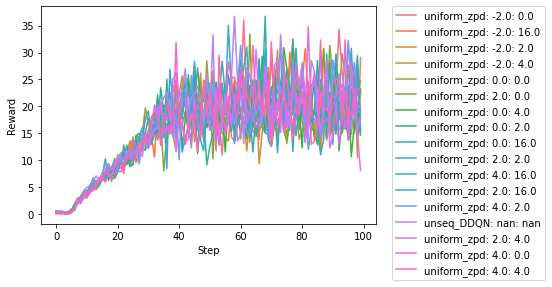

In [94]:


plot = sns.lineplot(x="Step", y= "Reward", hue="Config",ci = None,  data=all_test_returns_melt)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("figures/cumulative_test.pdf", bbox_inches = "tight")

In [71]:
all_play_returns_melt = pd.melt(all_play_returns, id_vars= ["agent", "offset", "radius", "seed"]
, var_name = "Step",value_name= "Reward", value_vars=list(range(0, min_num_episodes)))

all_play_returns_melt['Config'] = all_play_returns_melt["agent"].str.cat(all_play_returns_melt['offset'].astype(str), sep = ": ").str.cat(all_play_returns_melt['radius'].astype(str), sep = ": ")    



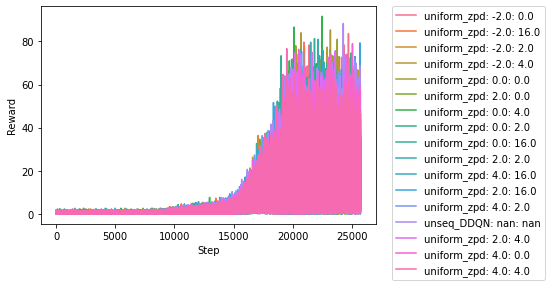

In [95]:
plot = sns.lineplot(x="Step", y= "Reward", hue="Config",ci = None,  data=all_play_returns_melt)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("figures/episodic_play.pdf", bbox_inches = "tight")